# Clustering data using scikit-learn

Clustering algorithms allow you to automatically find ways to group multidimentional data into clusters.

In this notebook, we'll use scikit-learn to predict clusters. 
scikit-learn provides implementations of many clustering algorithms.
As we experiment with each clustering algorithm, you'll see some of the advantages and drawbacks of each one.
The following algorithms are demonstrated in this notebook:

* k-means
* Mean shift
* DBSCAN
* Agglomerative clustering

To help visualize what we are doing, we'll use 3D charts to show how the clustering looks (with 3 selected dimensions) with two of the most popular Python visualization tools:

* matplotlib enhanced with seaborn styling and animation
* Plotly for a more interactive view (e.g., zoom and rotate a 3D chart with your mouse)

Finally, because we are playing with the same data that we use for supervised learning, we will look at how our unsupervised creation of clusters might create customer groups that have similar attributes. That is, will our customer groups happen to indicate a likely risk of churn. Please keep in mind that the point of this exercise is not to create a churn classifier, we are just using that to see how these customer clusters might be interesting.


## Setup

### Install python modules

> NOTE!  Some pip installs require a kernel restart.

The shell command `pip install` is used to install Python modules. Some installs require a kernel restart to complete.
To avoid confusing errors, run the following cell once and then restart the kernel before proceeding.


In [66]:
!pip install --user plotly==4.1.1
!pip install --user scikit-learn==0.21.3

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Load the customer and trading activity data

Use the cell below to load the merged_customers.csv file into a pandas DataFrame.

In [67]:
# Use the find data 10/01 icon and under "Files"
# upload the mergedcustomers.csv file and then
# use "Insert to code" and "Insert pandas DataFrame"
# here.

import pandas as pd
df_data_1 = pd.read_csv("../data/mergedcustomers.csv")


## Set the df variable and select from the DataFrame

Edit the following cell to reference the data loaded in the previous cell.

In [68]:
# After inserting the pandas DataFrame code above, change the following
# df_data_# to match the variable used in the above code. Once df is set
# the rest of the notebook will use the loaded data, as needed.

df = df_data_1

## Prepare the customer data

Remove the CHURNRISK column. We don't want to use that label for clustering, but we will save it to try some external evaluation of our clusters later.
Select just a few numeric columns as features for our clusters demos -- including gains minus losses combined into a single PROFIT_YTD.


In [69]:
# Save the CHURNRISK label column for later.
known_risk = df['CHURNRISK']

# Combine gains - losses into a profit column,
# and select a some of the numeric trader data to use for our customer clustering example.
keep_columns = ['AGE', 'TOTALUNITSTRADED', 'DAYSSINCELASTTRADE', 'DAYSSINCELASTLOGIN', 'PROFIT_YTD']
df_churn = df.assign(PROFIT_YTD=df.apply(lambda row: row.NETREALIZEDGAINS_YTD - row.NETREALIZEDLOSSES_YTD, axis=1).values)[keep_columns]
df_churn.head()

,AGE,TOTALUNITSTRADED,DAYSSINCELASTTRADE,DAYSSINCELASTLOGIN,PROFIT_YTD
0,47,58,13,2,-152.76525
1,25,13,10,4,1349.63500
2,42,28,5,4,1123.61250
3,52,36,6,3,-652.56550
4,40,8,9,4,-1496.14950


## Imports

Import the python modules that we need in the rest of the notebook.

In [70]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

## Prepare the scikit-learn datasets

Using the customer data is not the most obvious clustering experiment.
scikit-learn make_blobs() and make_moons() will give us some better examples for certain algorithms.


In [71]:
# Generate 10 features even though we generally only chart 3 (they are nice multidemensional, spherical clusters)
n_features = 10
n_samples = 1000
random_state = 100

# X is our generated data set.  y is the predicted cluster membership.
# Use of X and y vars is common in scikit-learn examples.
X, y = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)

# 2-dimensional moons dataset to show where some algorithms excel.
X_moons, y_moons = make_moons(n_samples=n_samples, noise=.05)

## Setup visualization

Configure seaborn to enhance our matplotlib charts.

In [72]:
sns.set(style='darkgrid', context='poster')  # , font_scale=2)
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = [10, 5]
RdYlBu = plt.get_cmap('RdYlBu')  # colormap for moons

Define some functions that will be used repeatedly for visualization.

In [73]:
from matplotlib import lines

# 3D matplotlib (plus seaborn) charting with some data prep and optional center points
def show_scatter_3d(data, x_index, y_index, z_index, predicted=None, centers=None,
                    marker='o', cmap=cm.Accent, alpha=0.5,
                    elev=25, azim=10, show_colorbar=True,
                    xlim3d=None, ylim3d=None, zlim3d=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = data[:,x_index]
    y = data[:,y_index]
    z = data[:,z_index]

    if centers is not None:
        spot_size=10  # Smaller spots make X more visible
        for center in centers:
            if center is not None:
                ax.scatter(center[x_index], center[y_index], center[z_index], marker="X", s=500, color='red')
    else:
        spot_size=30

    chart = ax.scatter(x, y, z, c=predicted, marker=marker, edgecolors='green', cmap=cmap, s=spot_size, alpha=alpha)
    
    # TODO: Add labels after deciding if the params should be indices or names
    # TODO: When deciding that also decide on DataFrame vs values.
    # ax.set_xlabel(x_name)
    # ax.set_ylabel(y_name)
    # ax.set_zlabel(z_name)
    
    # Optionally, set the axis limits:
    if xlim3d:
        ax.set_xlim3d(xlim3d)
    if ylim3d:
        ax.set_ylim3d(ylim3d)
    if zlim3d:
        ax.set_zlim3d(zlim3d)

    # Make room for axis titles
    plt.subplots_adjust(bottom=1, top=3, left=0, right=2)
    
    # Chart rotation
    ax.view_init(elev, azim)
    
    if show_colorbar:
        fig.colorbar(chart)
    
    return fig, ax
   

In [74]:
# Plotly 3D scatter chart is almost a one-liner, but use this function to keep the params in one place
def animate_scatter_3d(df, x, y, z, color=None):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color,
                    opacity=0.2, template='plotly_dark', color_continuous_scale=px.colors.qualitative.Set1)
    fig.show()

In [75]:
# Use a stacked bar chart for an external evaluation of the churn cluster vs known churn risk

# Map the risk values to sortables (and still OK for the legend)
risk_map = {'High': '2: High', 'Medium': '1: Medium', 'Low': '0: Low'}
    
# Reusable chart to see if our clusters might help with churn risk prediction
def show_risk_by_cluster(data, risk):
    
    # Create DataFrame with predicted CLUSTER ID
    data_df = pd.DataFrame(data=data, columns=['CLUSTER'])
    
    # Add CHURN_RISK using sortable values
    data_df['CHURN_RISK'] = risk.map(risk_map)
    
    # Group by and count to get count of Hi/Med/Low in each cluster
    grouped_data = data_df.groupby(['CLUSTER', 'CHURN_RISK']).size().to_frame().reset_index()
    
    # Pivot for charting
    pivot = grouped_data.pivot(index='CLUSTER', columns='CHURN_RISK', values=0).fillna(0)
    
    # Sort to show descending High and then ascending Low counts
    pivot = pivot.reindex(pivot.sort_values(by=['2: High', '0: Low'], ascending=[False, True]).index)

    # Plot the sorted stacked bar chart
    pivot.plot(kind='bar', stacked=True)

    # Put the legend on the side
    
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

## Visualize the input data sets

scikit-learn's make_blobs() generated hyperspheres and also returned a cluster membership (`y`).
Here we can visualize (3 selected features of) the data and use color to show the cluster membership. 
Later, we'll ignore the cluster membership, but try to "predict" clusters using various algorthms.

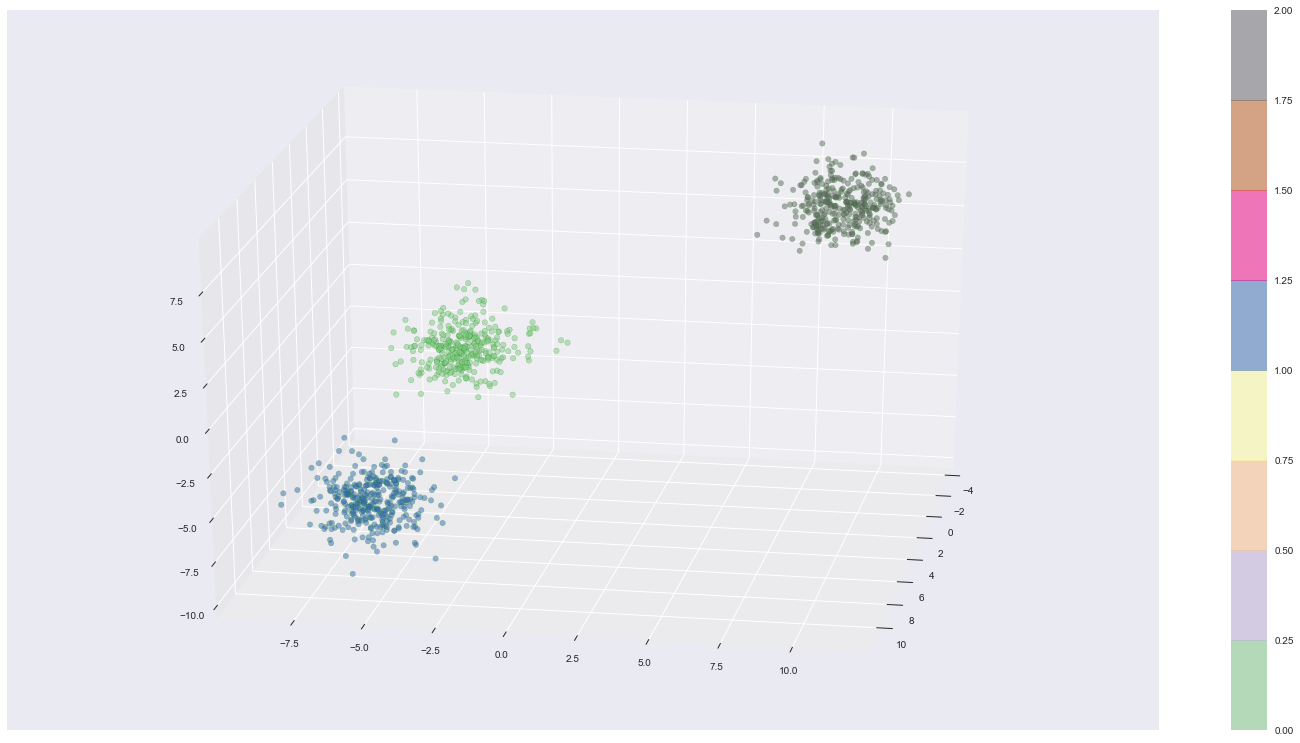

In [76]:
show_scatter_3d(X, 0, 1, 2, predicted=y);

In [77]:
# For Plotly, we'll put the data set in a DataFrame and give it some columns names.
X_df = pd.DataFrame(X)
X_df.columns = ['x', 'y', 'z', 'a', 'b', 'c', 'd', 'e', 'f', 'g']

# This is the same thing we just showed with matplotlib, but now we have tooltips and we can zoom and rotate.
# Rotating the chart can be very helpful when clusters are overlapping in 3-dimensional space.
animate_scatter_3d(X_df, 'x', 'y', 'z', color='g')

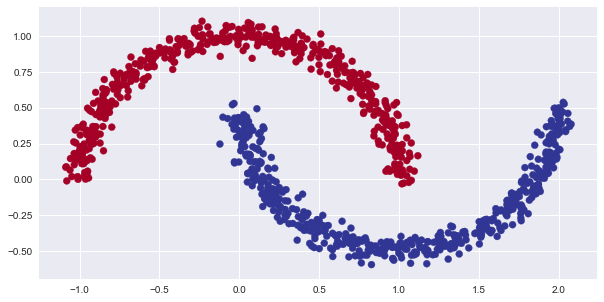

In [78]:
# The moons data set is only two-dimensional but demonstrates some cluster algorithm differences.

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=RdYlBu);

The customer data set is more like real world data. To visualize that we pick three features that we think are significant. We haven't predicted clusters yet, so we'll just show the color of the CHURNRISK label that we saved.

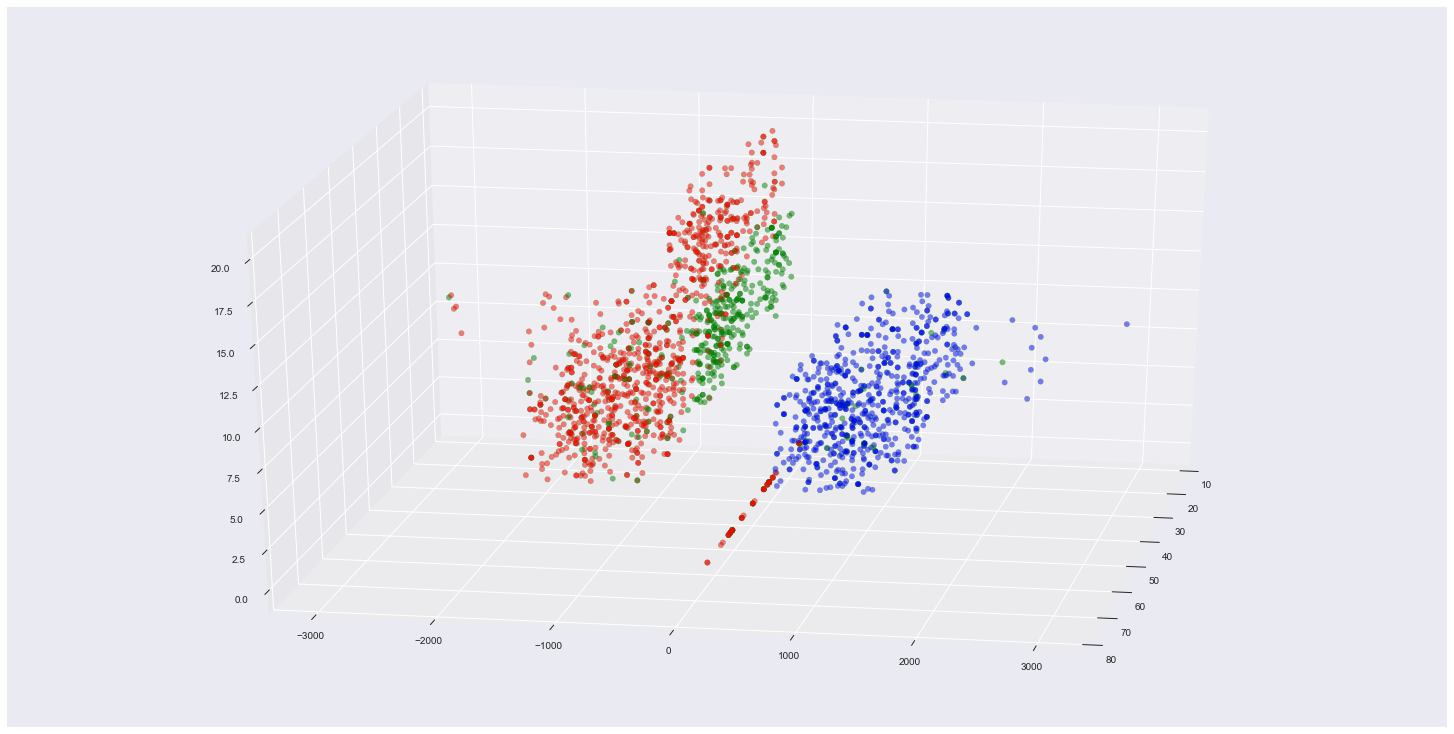

In [79]:
# Pick 3 features to show in 3D
x_name = 'AGE'
y_name = 'PROFIT_YTD'
z_name = 'DAYSSINCELASTTRADE'

# We did use k-means yet, let's just use the labels for color
label_colors = known_risk.map({'High': 'r', 'Medium': 'g', 'Low': 'b'})

x_index = df_churn.columns.get_loc(x_name)
y_index = df_churn.columns.get_loc(y_name)
z_index = df_churn.columns.get_loc(z_name)

show_scatter_3d(df_churn.values, x_index, y_index, z_index, predicted=label_colors, show_colorbar=False);

## Unsupervised learning with clustering

In general, for each algorthm, we will:

* Construct an instance with parameters and/or defaults for the clustering algorithm
* Call fit_predict() to predict cluster membership for our dataset using that instance
* Use charts to demonstrate the results
* Evaluate the results

### k-means

First, we look at k-means clustering.

* For k-means, you have to specify the number of clusters you want. We'll start with 3, but you can run this cell with different values to see what you get.
* We'll add a red `x` to show centriods, when we can.

### k-means with generated hyperspheres

Although we used 10 dimensions and only show 3, the generated hyperspheres are easy for the k-means algorithm to cluster as expected if you pick the correct number for clusters.  If you change `n_clusters`, you'll see that the clusters are combined or split in ways that might not make sense visually.

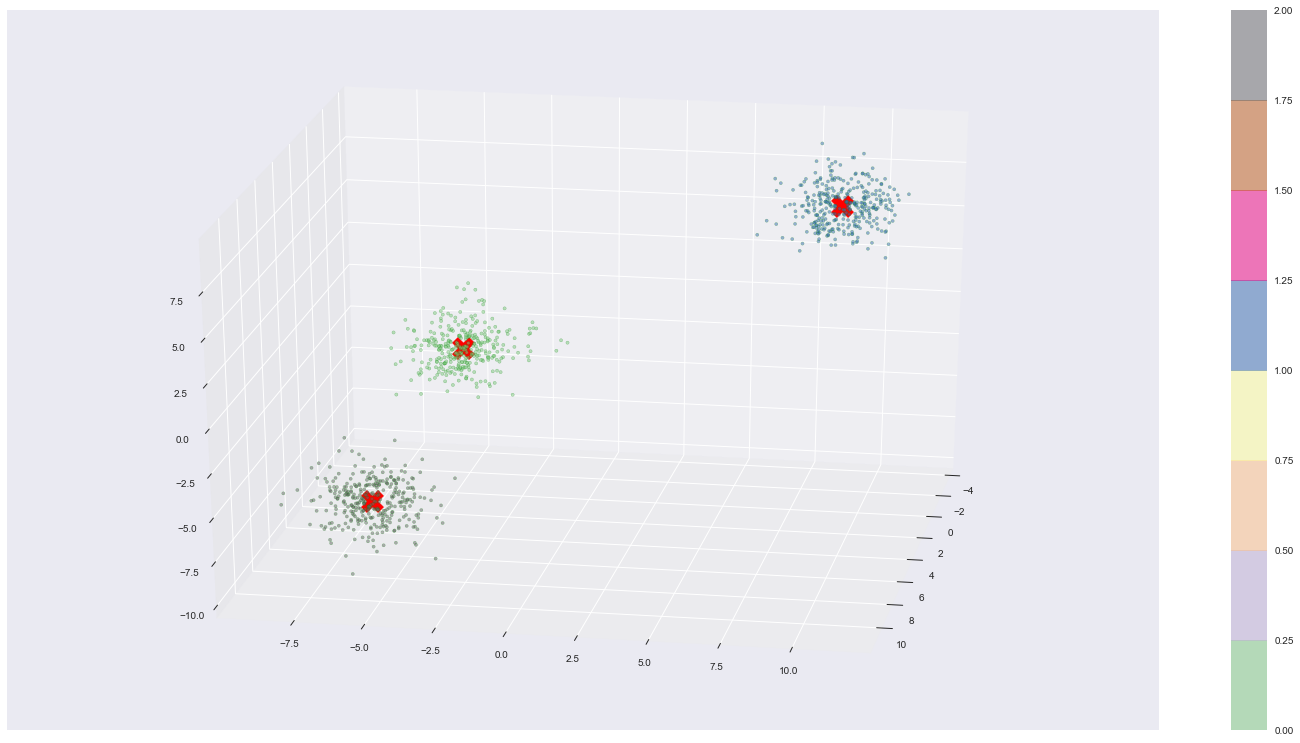

In [80]:
k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
show_scatter_3d(X, 0, 1, 2, predicted=y_pred, centers=centers);

### k-means with generated moons

The moons data, demonstrates a weakness of k-means. k-means does not recognize the dense crescent shapes which are easy to detect visually. k-means is limited to circles/spheres/hyperspheres. We choose n_clusters=2, but the result is probably not the best for this data set.


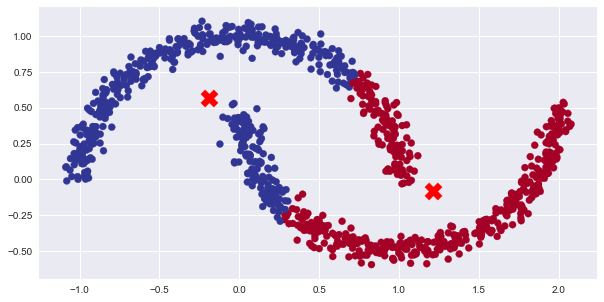

In [81]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_moons)
centers = kmeans.cluster_centers_

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred, cmap=RdYlBu);
for center in centers:
    plt.scatter(center[0], center[1], marker="X", s=300, color='red')

### k-means clustering with our customer data

k-means cluster using our selected customer features looks OK visually. It certainly would be nice if the `n_clusters` was more automatic. We're using n_clusters=3 (and you can experiment).

One thing you might notice is that there are outlier data points or smaller clusters that don't look right. Adjusting n_clusters can help, but an algorithm that understands the concept of outliers would be more helpful.


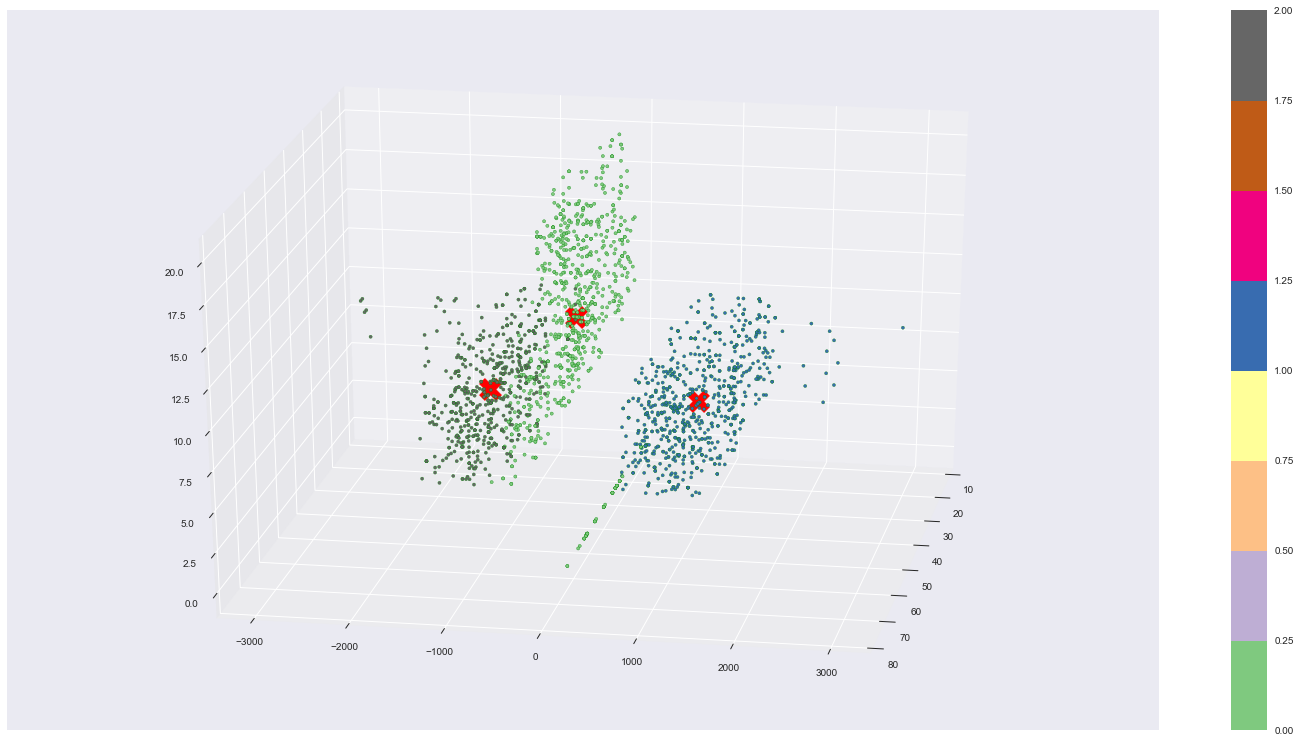

In [82]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
predicted = kmeans.fit_predict(df_churn.values)
centers = kmeans.cluster_centers_
show_scatter_3d(df_churn.values, x_index, y_index, z_index, predicted=predicted, centers=centers, alpha=1);

### External evaluation

We can do "external evaluation" by comparing the predicted clusters with the CHURNRISK label that we removed from the data.
You shouldn't expect unsupervised learning to be a good predictor of something so specific (supervised learning should work better),
but this demonstrates that these discovered customer groupings might have some things in common.

With n_clusters=3, you'll see that low risk customers were grouped pretty accurately. Another cluster is mostly high risk. The third group is high/medium.
You can run this again after predicting different numbers of clusters. Also, we'll see later how this compares to other algorithms.

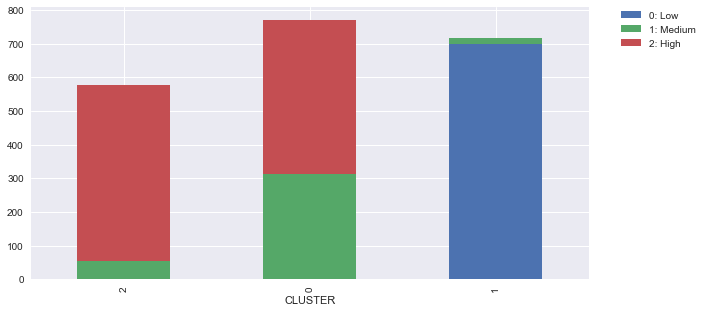

In [83]:
show_risk_by_cluster(predicted, known_risk)

#### Using Plotly

If you experimented above, you may have noticed that our k-means clusers were heavily influenced by the PROFIT_YTD column.
Using Plotly to rotate the chart and look at it from other angles can help you see that.


In [84]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
animate_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

## Mean shift

Mean shift is centroid-based like k-means, but has some advantages:

1. You don't need to specify n_clusters
2. It is not limited to hyperspheres
3. It recognizes density when seeking cluster centers


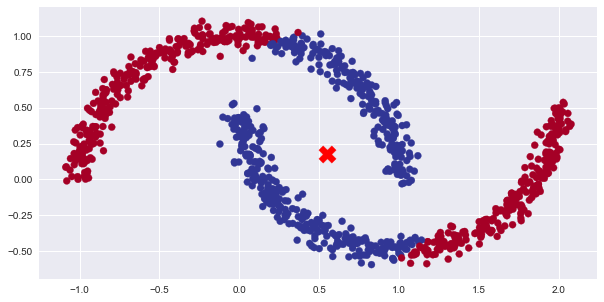

In [85]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X_moons, quantile=.3, n_samples=1000) 
ms = MeanShift(cluster_all=False, bandwidth=bandwidth)
y_pred = ms.fit_predict(X_moons)
centers = ms.cluster_centers_

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred, cmap=RdYlBu);
for center in centers:
    plt.scatter(center[0], center[1], marker="X", s=300, color='red')

In [86]:
from sklearn.cluster import MeanShift

ms = MeanShift(cluster_all=False)
predicted = ms.fit_predict(df_churn.values)
labels = ms.labels_
centers = ms.cluster_centers_

print("Number of clusters: ", len(centers))


Number of clusters:  5


Trying mean shift on our customer data, the first advantage is obvious:

* It automatically determined the number of clusters!

A second difference is less obvious, but if you ran k-means with n_clusters=5, you'll see that mean shift was able to create smaller clusters for some of our outlier points. Mean shift does not really understand "outliers" like some other algorithms, but separating the small clusters from the bigger clusters can have some of the same benefits.

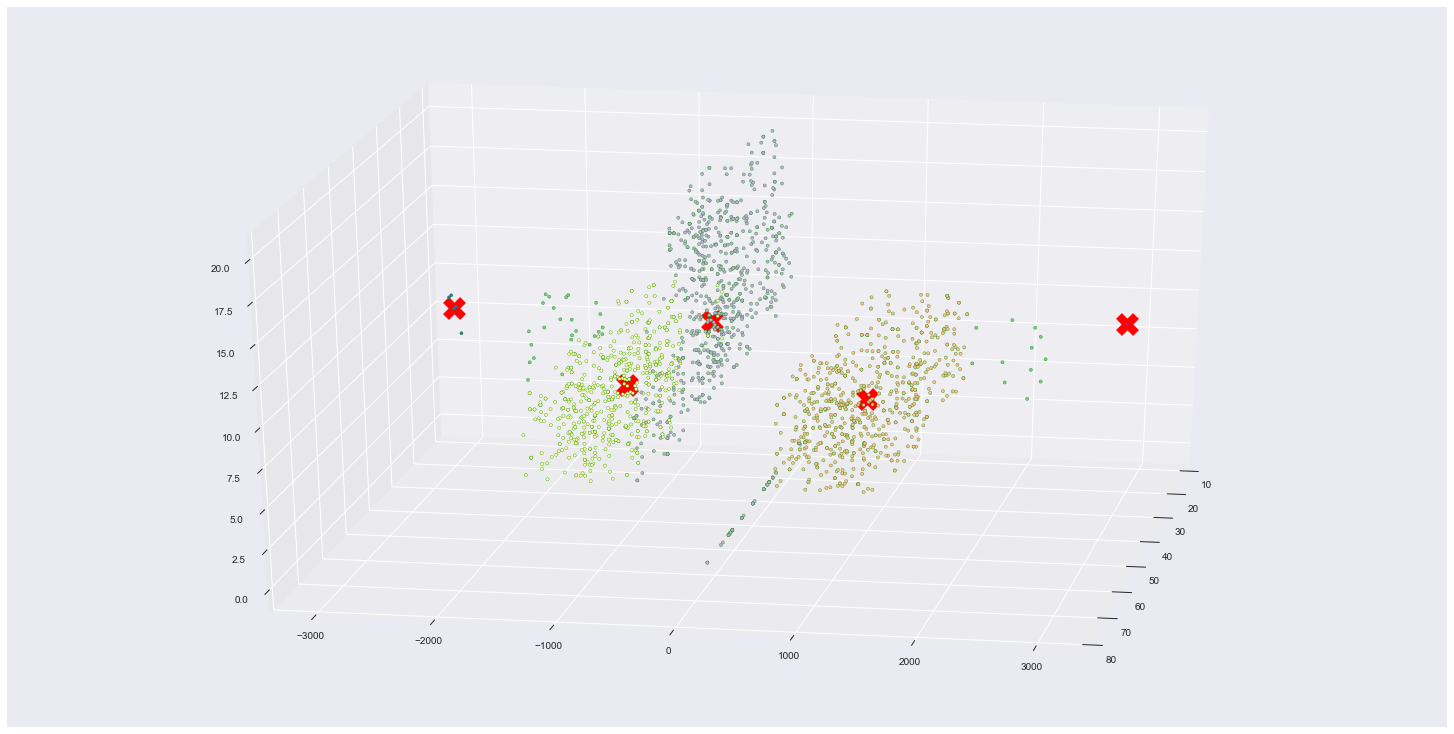

In [87]:
from matplotlib.colors import ListedColormap
show_scatter_3d(df_churn.values, x_index, y_index, z_index, predicted=predicted, centers=centers, alpha=1,
                show_colorbar=False,
                cmap=ListedColormap(cm.Accent.colors[:6]));


In [88]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
# temp_df.columns = [str(x) for x in temp_df.columns.values]
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

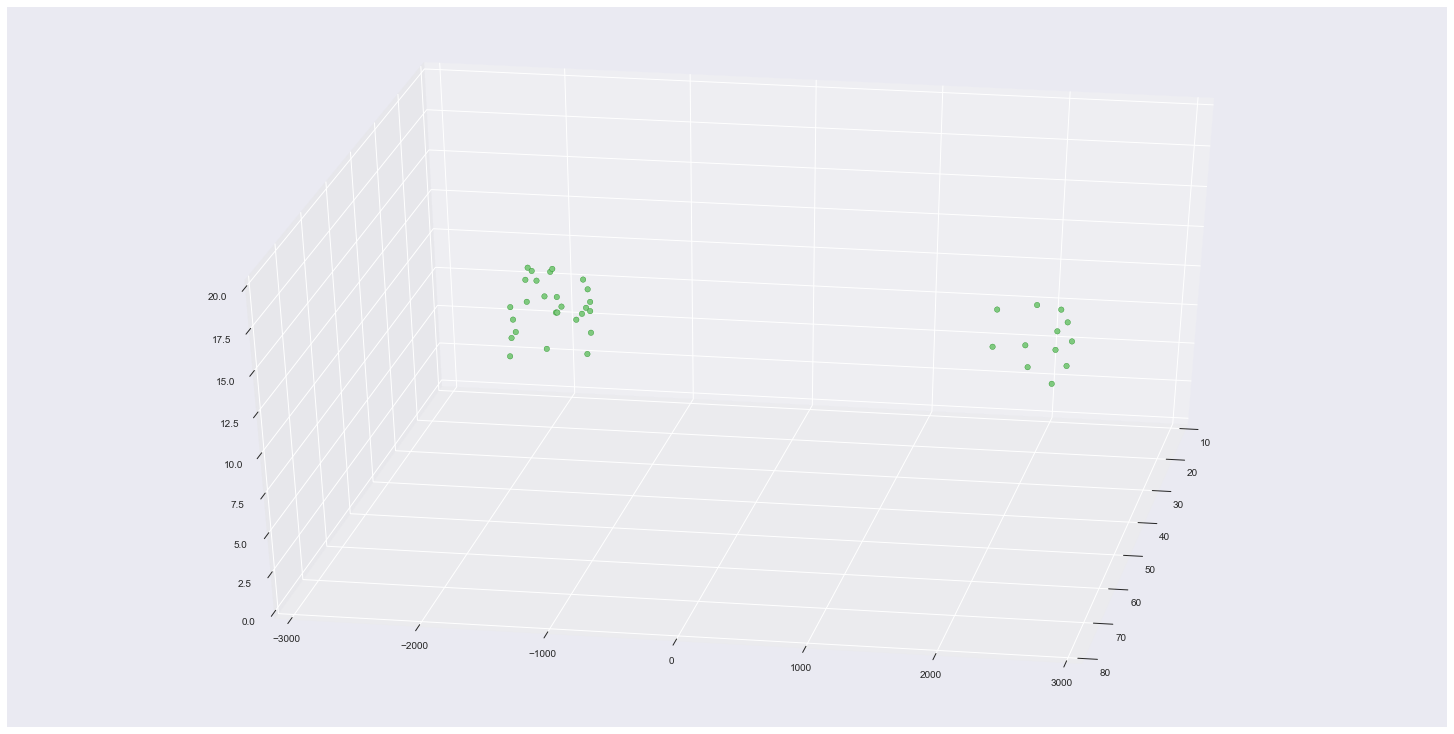

In [89]:

import matplotlib.animation
from IPython.display import display, clear_output
from time import sleep

charts = [
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])}
]

# n loops for more time to watch charts
loops = 2
for loop in range(loops):
  for chart in charts:
    clear_output(wait=True)
    fig, ax = show_scatter_3d(chart['dataframe'].values, x_index, y_index, z_index, predicted=chart['dataframe']['CLUSTER'],
                centers=chart['centers'], alpha=1, show_colorbar=False, cmap=chart['cmap'],
                elev=35, azim=10,
                xlim3d=(10, 80), ylim3d=(-3000, 3000), zlim3d=(0, 20))
        
    display(fig)
    plt.close(fig)
    sleep(1)

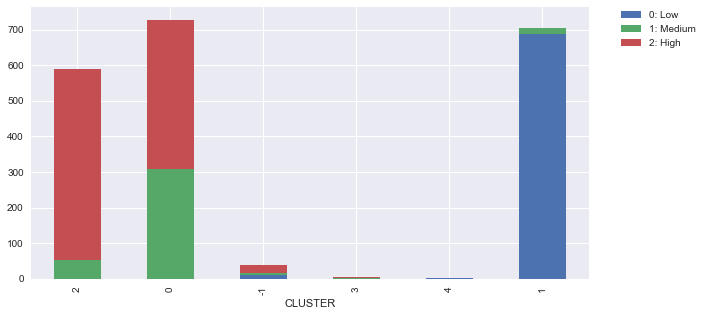

In [90]:
show_risk_by_cluster(predicted, known_risk)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Unlike mean shift, DBSCAN understands the concept of outliers. It will not create mini-clusters of outliers, but instead will take all the outliers and put them in cluster -1. These outliers are sometimes called "noise".

In addition, since DBSCAN is density-based and not centroid-based, it is able to predict cluster shapes that k-means and mean shift cannot predict.

For DBSCAN the eps parameter is important. With our customer data, we use the `eps` paramater to specify the maximum distance between samples. By trying different values, you will see that it has a strong influence on the number of clusters and the amount of noise. This behavior makes it difficult to use with out customer data set, but with eps=110 we can demonstrate clusters with noise removed.

A better example of how density-based clustering can recognize groups that centroid-based clustering cannot is our moons example.


In [91]:
from sklearn.cluster import DBSCAN
predicted = DBSCAN(eps=110).fit_predict(df_churn)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))


Number of clusters: 6
Number of outliers: 23


In [92]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
temp_df['KNOWN_RISK'] = known_risk
temp_df.columns = [str(x) for x in temp_df.columns.values]
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]
# animate_scatter_3d(no_outliers_df, 'DAYSSINCELASTTRADE', 'PROFIT_YTD', 'AGE', color='CLUSTER')

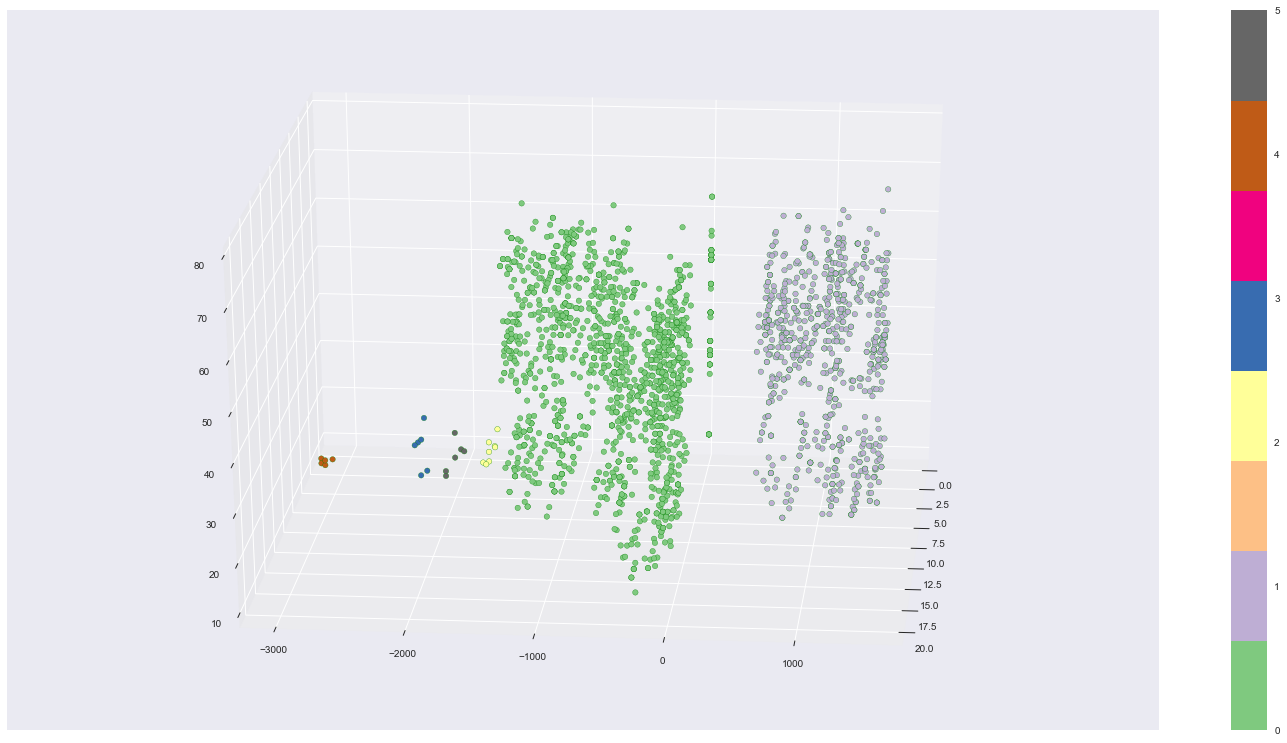

In [93]:
show_scatter_3d(no_outliers_df.values, 2, 4, 0, predicted=no_outliers_df['CLUSTER'], alpha=1, azim=5);

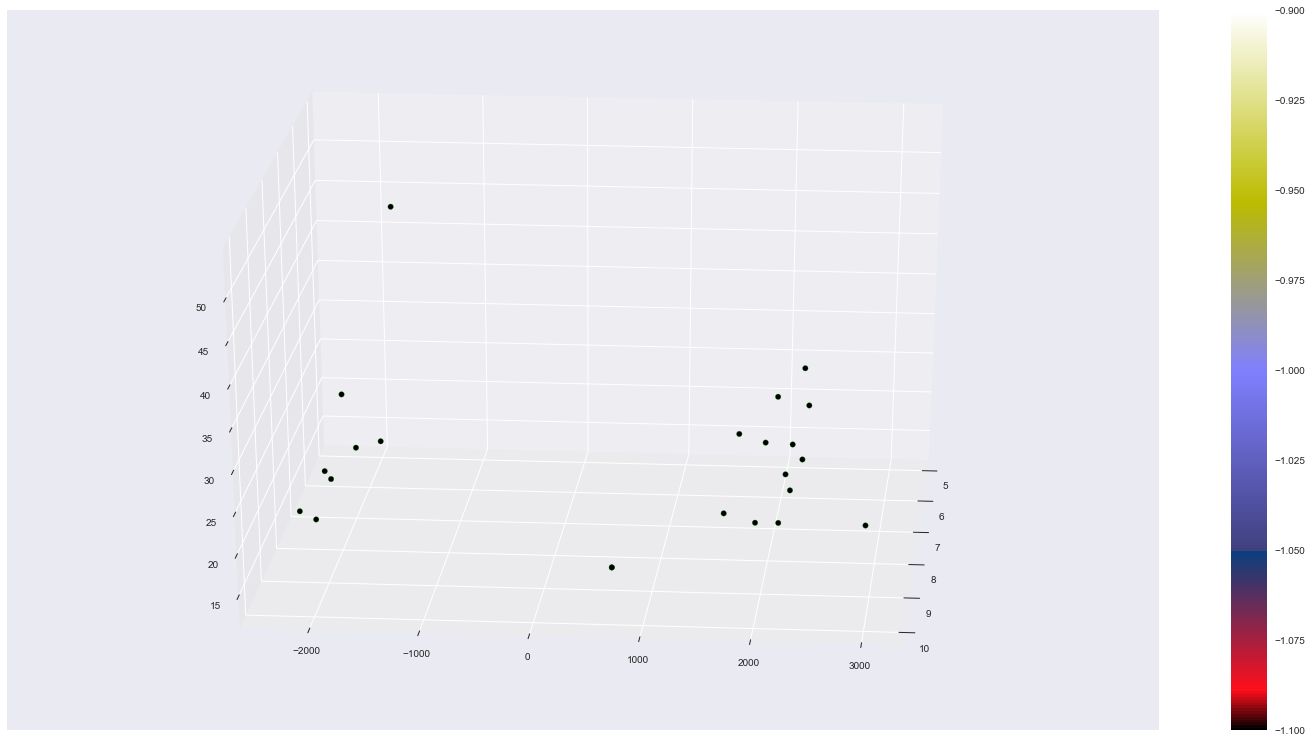

In [94]:
show_scatter_3d(outliers_df.values, 2, 4, 0, predicted=outliers_df['CLUSTER'], cmap=cm.gist_stern, alpha=1, azim=5);

### DBSCAN with generated moons

The moons data clearly demonstrates how density-based clustering can predict group "shapes" that centroid-based clustering cannot.


Number of clusters: 2
Number of outliers: 2


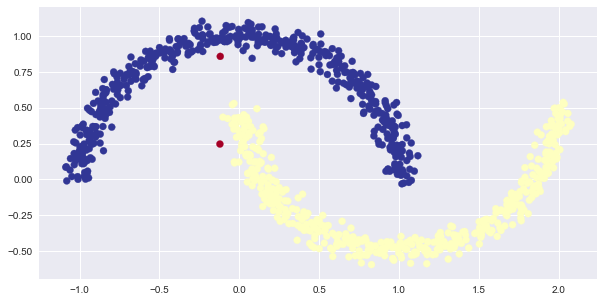

In [95]:
predicted = DBSCAN(eps=.1).fit_predict(X_moons)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=predicted, cmap=RdYlBu);

## Hierarchical


In [96]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=500, 
                             affinity='euclidean', linkage='complete')
predicted = ac.fit_predict(df_churn.values)

print('Number of clusters:', len(set(predicted)))

Number of clusters: 14


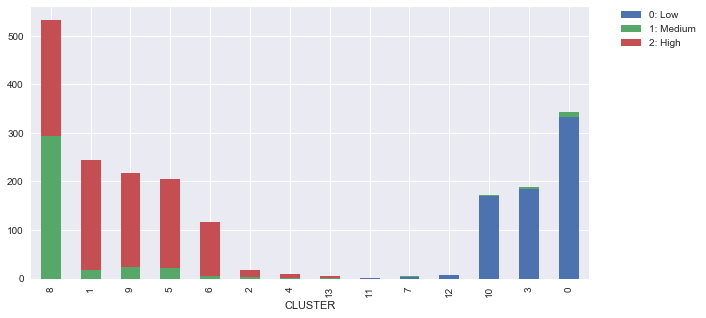

In [97]:
show_risk_by_cluster(predicted, known_risk)

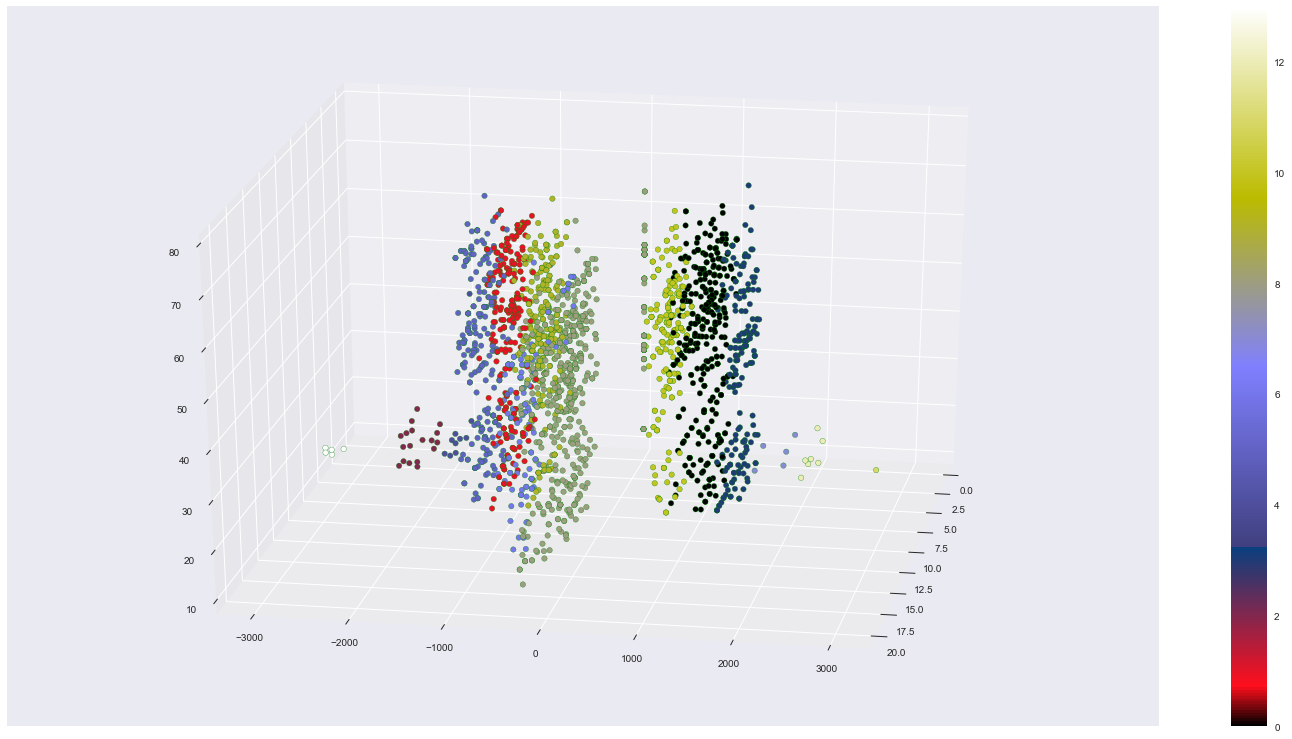

In [98]:
show_scatter_3d(df_churn.values, 2, 4, 0, predicted=predicted, cmap=cm.gist_stern, alpha=1);


In [99]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
animate_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

<p><font size=-1 color=gray>
&copy; Copyright 2019 IBM Corp. All Rights Reserved.
<p>
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the
License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
express or implied. See the License for the specific language governing permissions and
limitations under the License.
</font></p>